<h1 style="text-align: center">
Deep Learning HW4 </br>
VQ-VAE
</h1>




### Full Name: Amirabbas Afzali
### Student ID: 400100662



<p style="color:yellow;">This implemenation is based on the paper "Neural Discrete Representation Learning (DeepMind,  2018)".</p>

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the MNIST dataset and data loader

In [4]:
import os
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# I added the num_workers=os.cpu_count(), pin_memory=False statements
batch_size = 128
x_dim = 28 * 28
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 92240220.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40031623.87it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32200635.07it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 19146260.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [5]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(8, 16)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

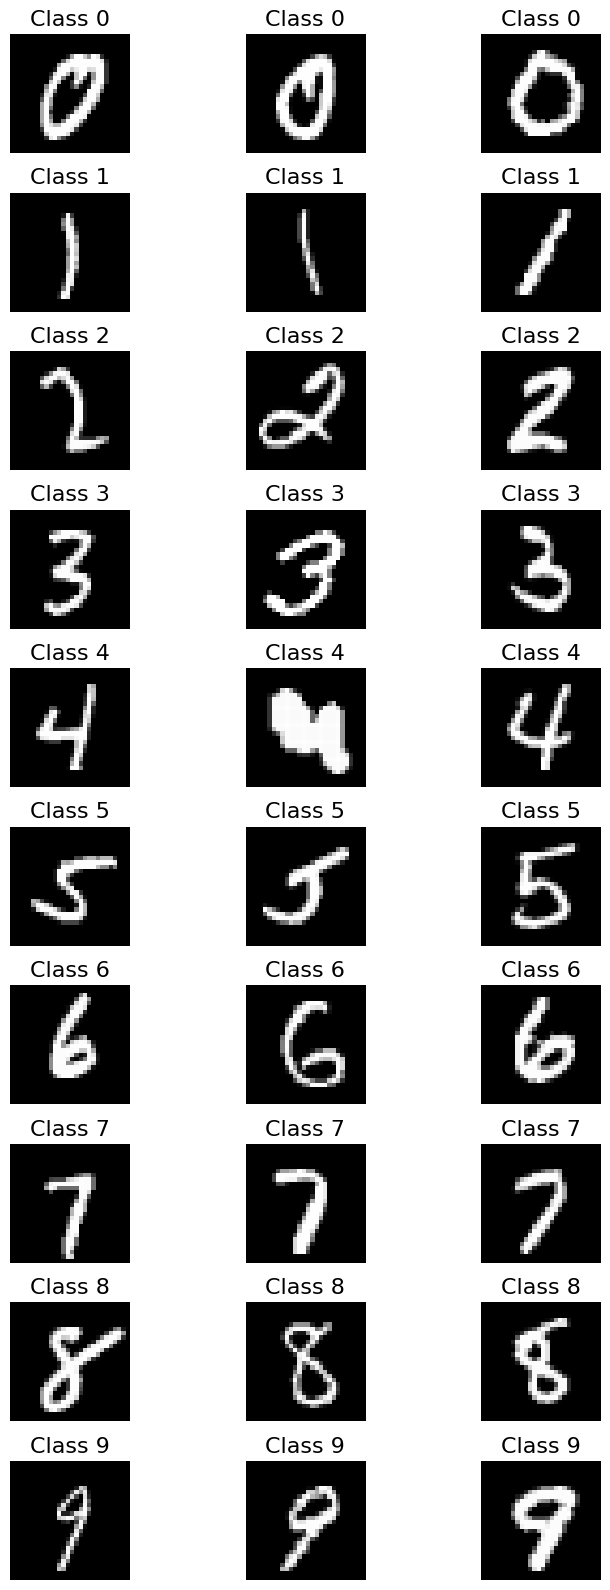

In [6]:
show_random_images_from_each_class(train_dataset, num_images_per_class=3)

# Define NETWORK

- Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim,latent_dim):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(input_dim, 256, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(256, latent_dim, 4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(latent_dim)
        # self.bn1 = nn.BatchNorm2d(64)
        # self.bn1 = nn.BatchNorm2d(64)

        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(latent_dim, latent_dim, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(latent_dim, latent_dim, 1)
            ) for _ in range(2)
        ])

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        for block in self.residual_blocks:
            x = x + block(x)
        return x


- Decoder

In [7]:
class Decoder(nn.Module):
    def __init__(self, input_dim, dim_embed=1):
        super(Decoder, self).__init__()

        self.deconv1 = nn.ConvTranspose2d(input_dim, 256, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, dim_embed, 4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.bn1(self.deconv1(x)))
        x = self.relu(self.bn2(self.deconv2(x)))
        x = self.relu(self.bn3(self.deconv3(x)))
        out = self.deconv4(x)
        return out


- Quantizer

In [8]:
class Quantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(Quantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        nn.init.uniform_(self.embedding.weight, -1.0, 1.0)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_flatten = x.view(-1, self.embedding_dim)

        distances = torch.sum(x_flatten.pow(2), dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight.pow(2) , dim=1) - \
            2*torch.matmul(x_flatten, self.embedding.weight.t())

        indices = torch.argmin(distances, dim=1).unsqueeze(1) # find nearest embeddings
        encodings = torch.zeros(indices.shape[0], self.num_embeddings, device=x.device)
        encodings.scatter_(1, indices, 1)

        quantized = torch.matmul(encodings, self.embedding.weight).view(x.shape)

        return quantized, encodings

- Loss function

$$\mathcal{L}=\log \left(p\left(x \mid z_q(x)\right)\right)+\left\|z_e(x) \cdot \operatorname{detach}()-e\right\|_r^r+\beta\left\|z_e(x)-e \cdot \operatorname{detach}()\right\|_r^r$$

$$ \text{perplexity} = \exp\left(-\sum_{i=1}^{N} p(i) \log(p(i) + \epsilon)\right) $$

Where:
- $N$ is the number of elements in the probability distribution.
- $p(i)$ represents the average probability of the i-th element.
- $\epsilon$ is a small constant to avoid taking the logarithm of zero.


In [9]:
class VQVAELoss(nn.Module):
    def __init__(self, beta):
        super(VQVAELoss, self).__init__()
        self.beta = beta
        self.eps = 1e-10

    def forward(self, z ,quantized, encodings,reconstructed, input):
        z = z.permute(0, 2, 3, 1).contiguous()

        # losses
        codebook_loss = F.mse_loss(z.detach(), quantized)
        commitment_loss = F.mse_loss(z, quantized.detach())
        reconst_loss = F.mse_loss(reconstructed, input)
        total_loss = reconst_loss + codebook_loss + self.beta*commitment_loss

        # perplexity
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + self.eps)))

        return total_loss , perplexity


- VQ_VAE model

$decoder \; input = encoder(X)+(codebook(encoder(X))-encoder(X)) \cdot \operatorname{detach}()$

In [10]:
class VQ_VAE(nn.Module):
    def __init__(self, input_dim=1,num_embeddings = 3, embedding_dim = 2, beta=0.25):
        super(VQ_VAE, self).__init__()

        self.encoder = Encoder(input_dim, embedding_dim)
        self.codebook = Quantizer(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim, input_dim)
        self.VQVAELoss_ = VQVAELoss(beta)

    def forward(self, x):
        z = self.encoder(x)
        z_quantized, encodings = self.codebook(z)
        dec_input = z + (z_quantized.permute(0, 3, 1, 2).contiguous() - z).detach()
        reconstructed = self.decoder(dec_input)

        loss, perplexity = self.VQVAELoss_(z ,z_quantized, encodings,
                                           reconstructed, x)

        return reconstructed, loss, perplexity

    def trainer(self, data_loader, optimizer,device='cuda', num_epochs=30, report=False):

      train_losses = []
      train_perplexities = []
      codebook_vectors_list = []

      for epoch in range(num_epochs):
          self.train()
          running_loss = 0
          running_perplexity = 0
          for (x, y) in data_loader:
              x = x.to(device)

              optimizer.zero_grad()
              x_hat, loss, perplexity = self(x)
              running_loss += loss.item()
              running_perplexity += perplexity.item()

              loss.backward()
              optimizer.step()

          avg_loss = running_loss / len(data_loader)
          avg_perplexity = running_perplexity / len(data_loader)
          codebook_vectors = self.codebook.embedding.weight.data.cpu().numpy()

          train_losses.append(avg_loss)
          train_perplexities.append(avg_perplexity)
          codebook_vectors_list.append(codebook_vectors)
          if report:
            print(f'Epoch {epoch+1}: Loss: {avg_loss:.4f}, Perplexity: {avg_perplexity:.4f}')

      return model, (train_losses, train_perplexities, codebook_vectors)


    def plot_some_output(self, data_loader, num_examples, device,ax=None):
      for (x,y) in data_loader:
        x = x[:num_examples].to(device)
        break

      self.eval()
      with torch.no_grad():
          outputs, _ ,_= self(x)

      x = x.cpu().numpy()
      outputs = outputs.cpu().numpy()
      if ax is None:
        fig, ax = plt.subplots(2, num_examples, figsize=(15, 6))

      for i in range(num_examples):

          x[i] = np.clip(x[i], a_min=0, a_max=1)
          outputs[i] = np.clip(outputs[i], a_min=0, a_max=1)
          ax[0, i].imshow(x[i].transpose(1, 2, 0))
          ax[0, i].set_title(f'Input {i + 1}')

          ax[1, i].imshow(outputs[i].transpose(1, 2, 0))
          ax[1, i].set_title(f'Output {i + 1}')

      return ax

In [12]:
model = VQ_VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [13]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

epochs = 30

train_losses = []
train_perplexities = []
codebook_vectors_list = []

for epoch in range(epochs):
    model.train()

    running_loss = 0
    running_perplexity = 0

    for (x, y) in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, loss, perplexity = model(x)

        running_loss += loss.item()
        running_perplexity += perplexity.item()

        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(train_loader)
    avg_perplexity = running_perplexity / len(train_loader)
    codebook_vectors = model.codebook.embedding.weight.data.cpu().numpy()

    train_losses.append(avg_loss)
    train_perplexities.append(avg_perplexity)
    codebook_vectors_list.append(codebook_vectors)

    print(f'Epoch {epoch+1}: Loss: {avg_loss:.4f}, Perplexity: {avg_perplexity:.4f}')



<IPython.core.display.Javascript object>

Epoch 1: Loss: 0.2009, Perplexity: 1.7213
Epoch 2: Loss: 0.0935, Perplexity: 1.6877
Epoch 3: Loss: 0.0918, Perplexity: 1.7006
Epoch 4: Loss: 0.0916, Perplexity: 1.7114
Epoch 5: Loss: 0.0913, Perplexity: 1.7136
Epoch 6: Loss: 0.0906, Perplexity: 1.7174
Epoch 7: Loss: 0.0893, Perplexity: 1.7215
Epoch 8: Loss: 0.0874, Perplexity: 1.7290
Epoch 9: Loss: 0.0861, Perplexity: 1.7380
Epoch 10: Loss: 0.0737, Perplexity: 2.3837
Epoch 11: Loss: 0.0615, Perplexity: 2.8553
Epoch 12: Loss: 0.0587, Perplexity: 2.8660
Epoch 13: Loss: 0.0573, Perplexity: 2.8769
Epoch 14: Loss: 0.0566, Perplexity: 2.8822
Epoch 15: Loss: 0.0557, Perplexity: 2.8843
Epoch 16: Loss: 0.0550, Perplexity: 2.8858
Epoch 17: Loss: 0.0545, Perplexity: 2.8862
Epoch 18: Loss: 0.0537, Perplexity: 2.8856
Epoch 19: Loss: 0.0532, Perplexity: 2.8853
Epoch 20: Loss: 0.0529, Perplexity: 2.8844
Epoch 21: Loss: 0.0526, Perplexity: 2.8832
Epoch 22: Loss: 0.0523, Perplexity: 2.8812
Epoch 23: Loss: 0.0519, Perplexity: 2.8806
Epoch 24: Loss: 0.05

Training loss and perplexity visualization :

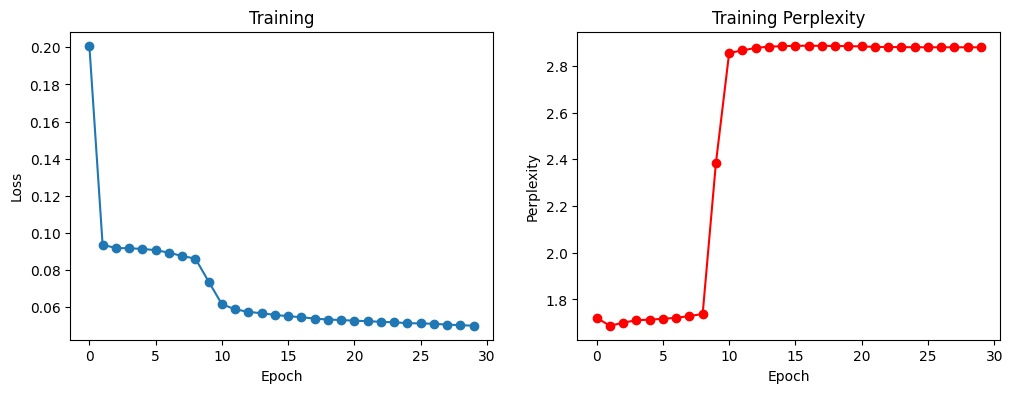

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses,marker='o')
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(train_perplexities,marker='o',color='r')
plt.title('Training Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')

plt.show()

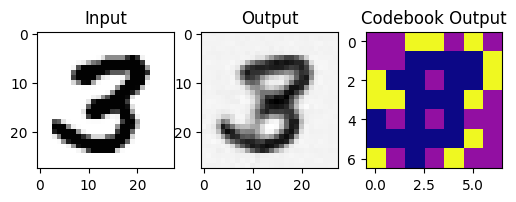

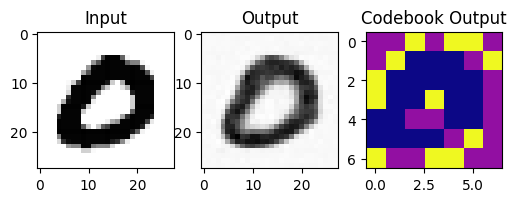

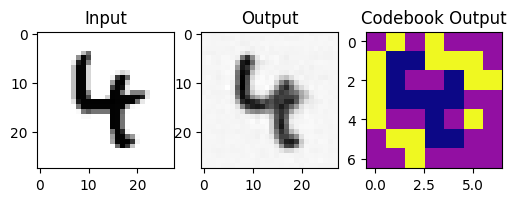

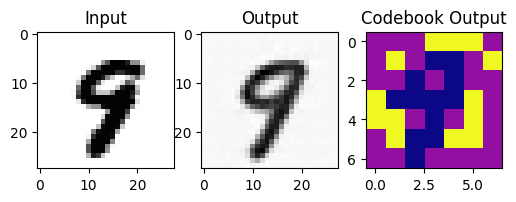

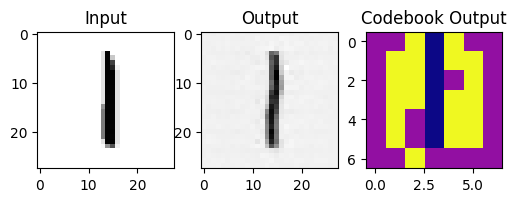

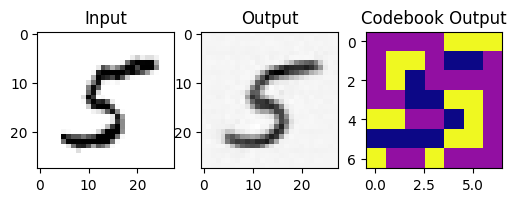

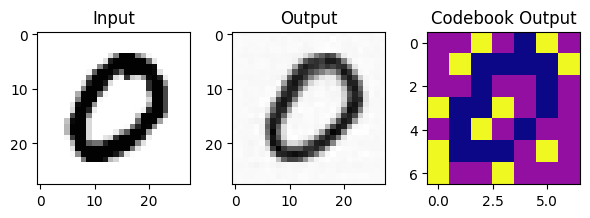

In [15]:

num_examples = 7
for (x,y) in train_loader:
  x = x[:num_examples].to(device)
  break


model.eval()
with torch.no_grad():
    encoded = model.encoder(x)
    codebook_output, _ = model.codebook(encoded)
    codebook_output = codebook_output.permute(0, 3, 1, 2).contiguous()
    outputs = model.decoder(codebook_output)

# print(outputs.shape)
inputs = x.cpu().numpy()
outputs = outputs.cpu().numpy()
codebook_output = ((codebook_output[:, 0:1, :, :]) + (codebook_output[:, 1:2, :, :])) / 2
codebook_output = codebook_output.cpu().numpy()
embedding_vectors = model.codebook.embedding.weight.data.cpu().numpy()


for index in range(num_examples):

    plt.figure(figsize=(6 , 4))

    plt.subplot(1,3, 1)
    plt.imshow(inputs[index].transpose(1, 2, 0), cmap='Greys')
    plt.title('Input')

    plt.subplot(1,3, 2 )
    plt.imshow(outputs[index].transpose(1, 2, 0), cmap='Greys')
    plt.title('Output')

    plt.subplot(1, 3, 3)
    plt.imshow(codebook_output[index].transpose(1, 2, 0),cmap='plasma')
    plt.title('Codebook Output')

plt.tight_layout()
plt.show()


### Create a GIF for Codebook Vectors Over Training epochs

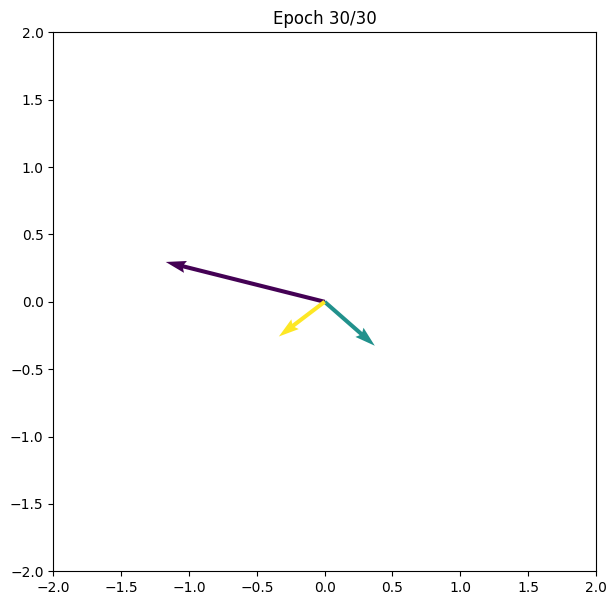

In [16]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(7, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding_vectors)))  # Generating a range of colors based on the length of embedding_vectors

def update(frame):
    ax.clear()  # Clearing the axes for the new frame
    ax.quiver(np.zeros(3), np.zeros(3),
              codebook_vectors_list[frame][:, 0],
              codebook_vectors_list[frame][:, 1],
              angles='xy', scale_units='xy', scale=1, color=colors)

    ax.set_title(f'Epoch {frame + 1}/{30}')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

ani = FuncAnimation(fig, update, frames=len(codebook_vectors_list), repeat=False)  # Creating the animation
ani.save('/content/drive/My Drive/Q4/codebook_vectors.gif', writer='imagemagick', fps=8)  # Saving the animation as a GIF with specified parameters
plt.show()

## Effect of different sizes:

## Coloured dataset

In [11]:
class Coloured_MNIST_Dataset(Dataset):
    def __init__(self, root, train=True, transform=None, download=True, random_seed=42):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.random_seed = random_seed # for reproducibility
        self.random_state = torch.manual_seed(self.random_seed)

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):

        torch.manual_seed(self.random_seed * idx)
        data, target = self.mnist_dataset[idx]
        Coloured_data = data.repeat( 3, 1, 1)

        Coloured_data[0] *= torch.rand(1)
        Coloured_data[1] *= torch.rand(1)
        Coloured_data[2] *= torch.rand(1)

        return Coloured_data, target

- example

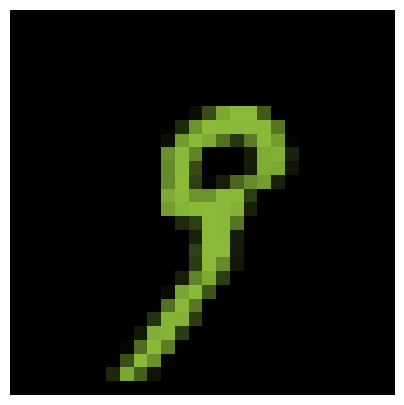

In [12]:
transform = transforms.Compose([transforms.ToTensor()])

coloured_dataset = Coloured_MNIST_Dataset(root='./data', train=True, transform=transform, download=True)

batch_size = 128
coloured_loader = DataLoader(coloured_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False)

example_data, _ = coloured_dataset[19]

show_image(example_data.cpu().numpy().transpose(1, 2, 0))

## Effect of number of embeddings

- training models

In [19]:
NumEmbeddings = [3, 5, 10, 20, 30, 40, 50]

models_NumEmbeddings = []

for num in tqdm(NumEmbeddings):
  model = VQ_VAE(input_dim=3, num_embeddings=num).to(device)
  optimizer = optim.Adam(model.parameters(), lr=5e-4)
  model, metrices = model.trainer(coloured_loader,optimizer,device=device,num_epochs=20,report =False)

  models_NumEmbeddings.append((model, optimizer,metrices))


100%|██████████| 7/7 [38:23<00:00, 329.09s/it]


- plot some example

With 3 embedding vectors: 
final loss: 0.0344, final perplexity: 2.3396


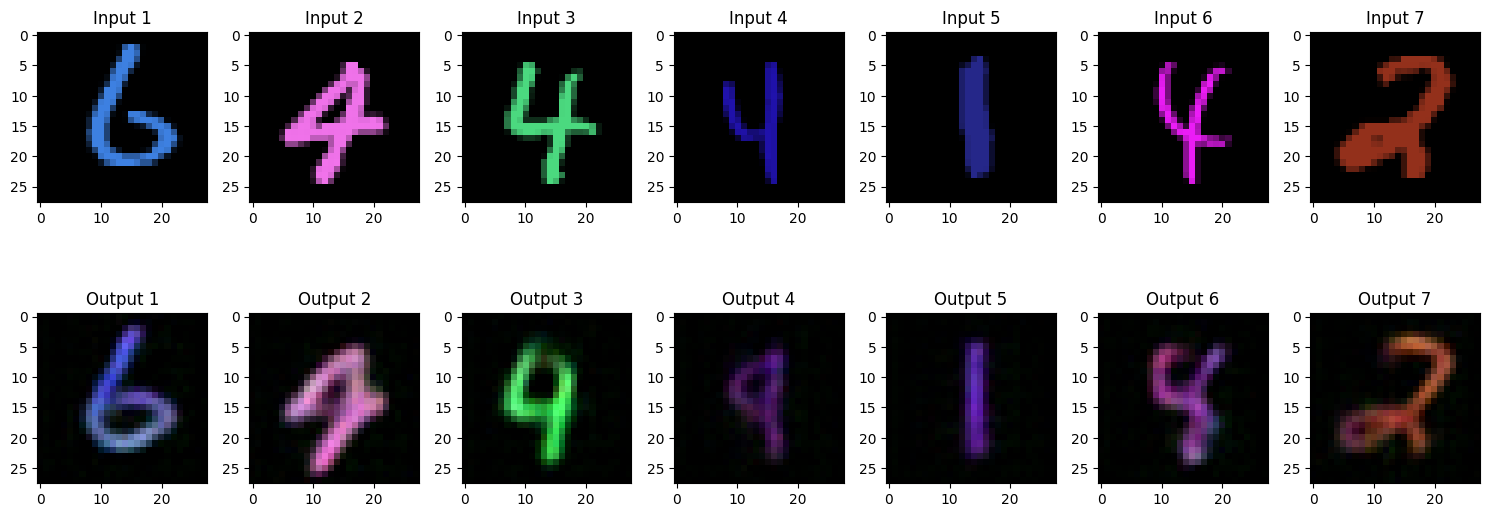

With 5 embedding vectors: 
final loss: 0.0267, final perplexity: 1.0000


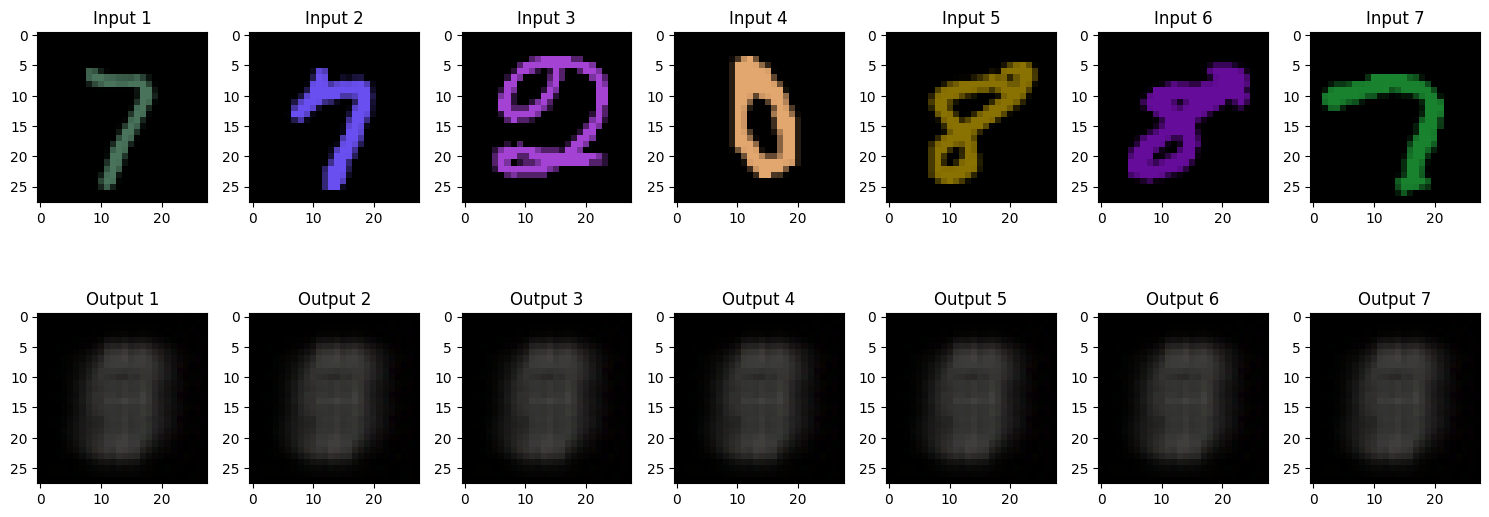

With 10 embedding vectors: 
final loss: 0.0156, final perplexity: 7.5872


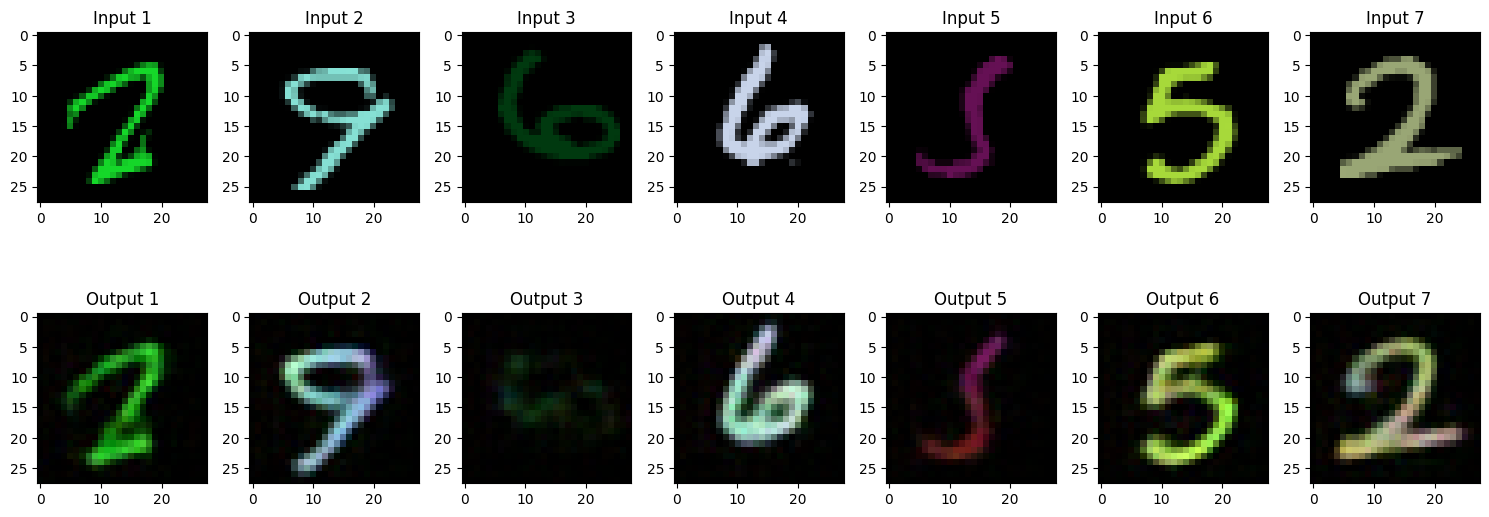

With 20 embedding vectors: 
final loss: 0.0085, final perplexity: 15.1832


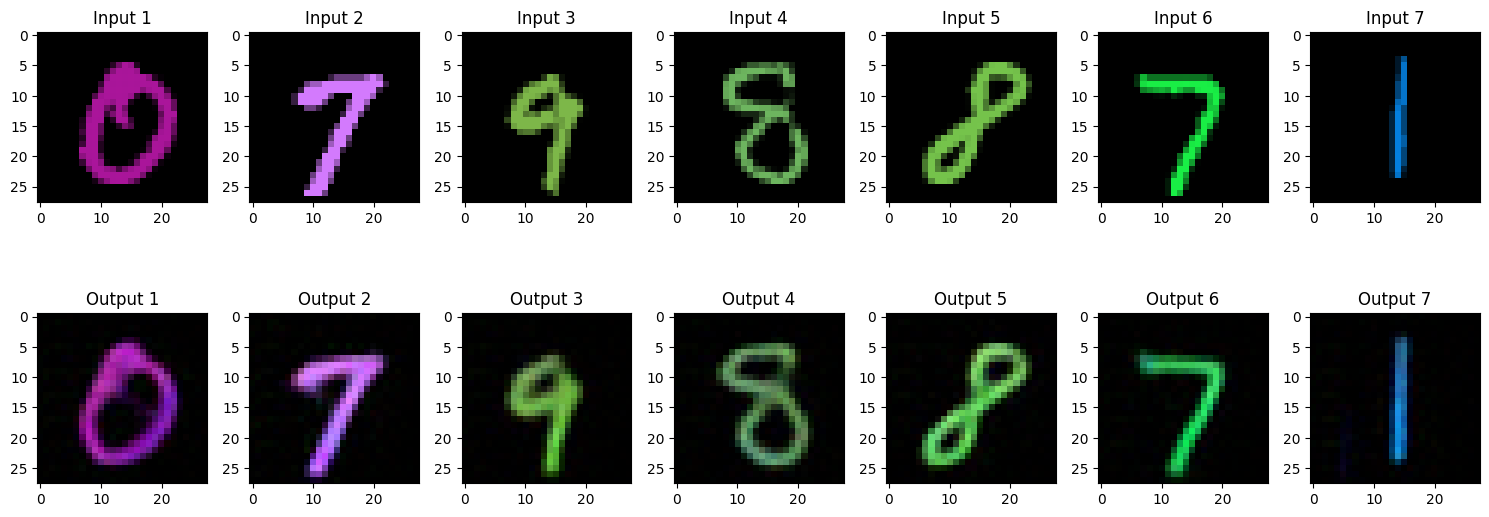

With 30 embedding vectors: 
final loss: 0.0074, final perplexity: 17.6281


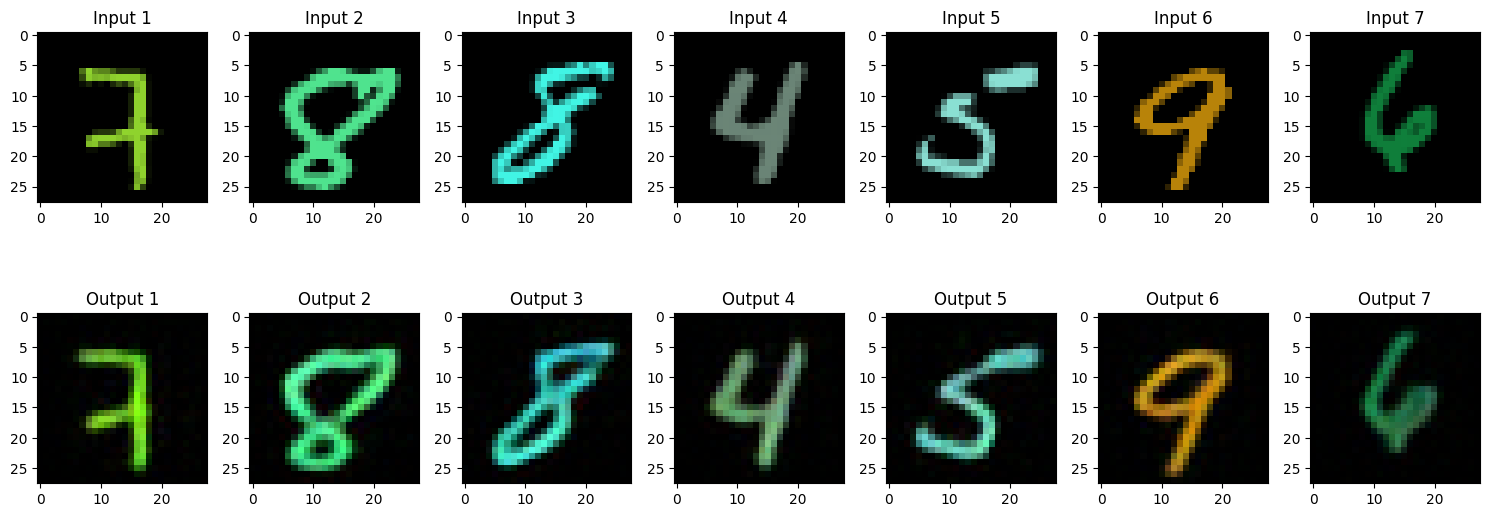

With 40 embedding vectors: 
final loss: 0.0067, final perplexity: 19.2516


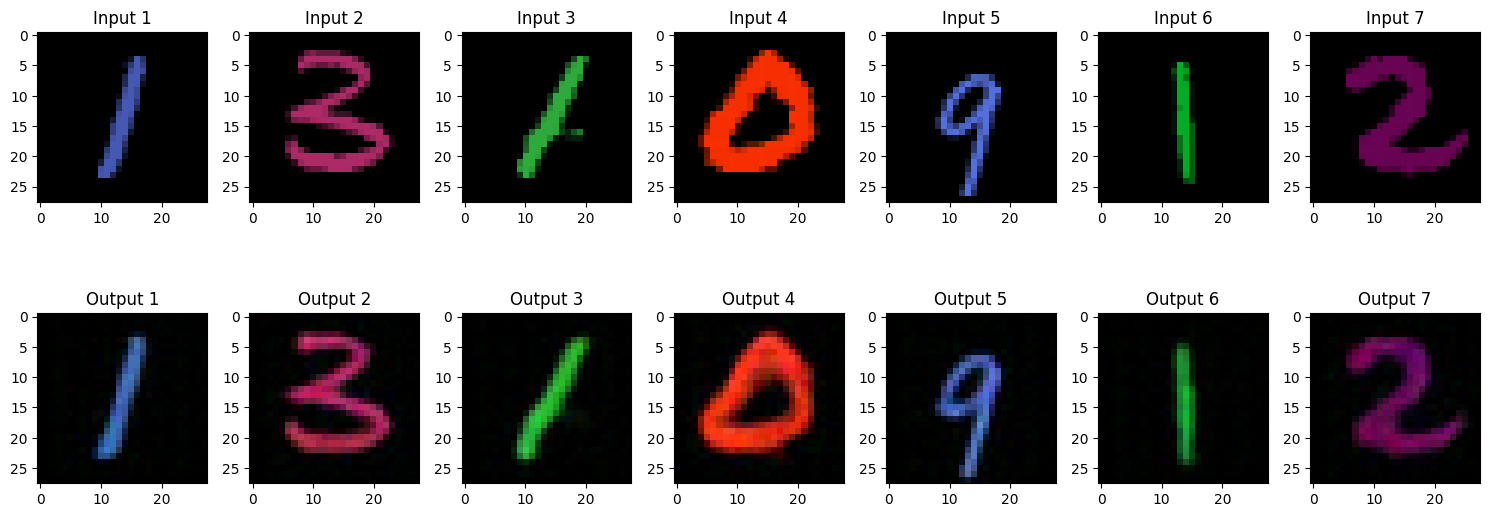

With 50 embedding vectors: 
final loss: 0.0079, final perplexity: 16.3883


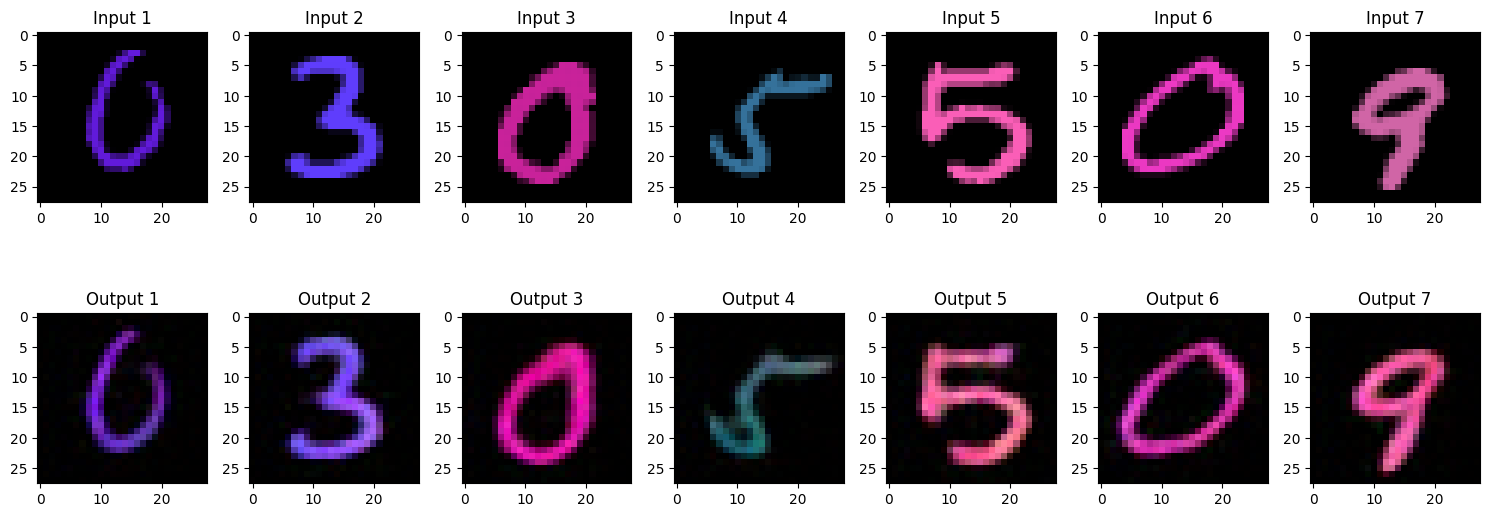

In [20]:
for index, (model,_, metrices) in enumerate(models_NumEmbeddings):
    print(f'With {NumEmbeddings[index]} embedding vectors: ')
    final_loss = metrices[0][-1]
    final_perplexity = metrices[1][-1]
    print(f'final loss: {final_loss:.4f}, final perplexity: {final_perplexity:.4f}')
    model.plot_some_output(coloured_loader, 7, device)
    plt.tight_layout()
    plt.show()


- Compaire Training loss and perplexity

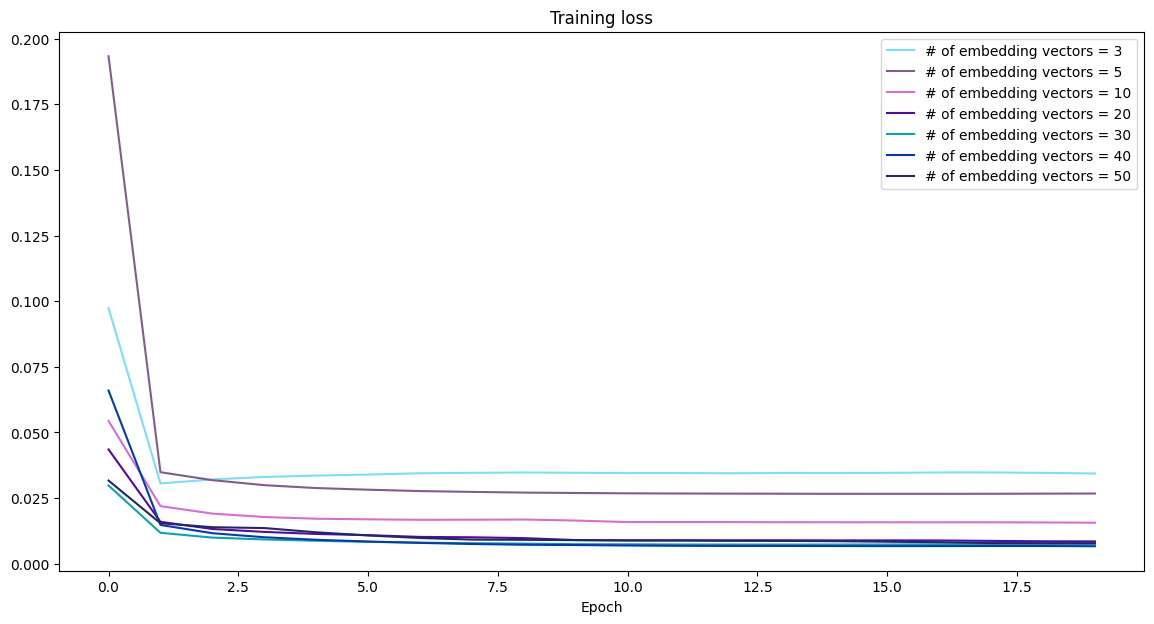

In [26]:
plt.figure(figsize=(14, 7))
legend_ = []

for index, (_,_, metrices) in enumerate(models_NumEmbeddings):
    color = np.random.rand(3,)
    plt.plot(metrices[0],color=color)
    legend_.append(f'# of embedding vectors = {NumEmbeddings[index]}')

plt.legend(legend_)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.show()


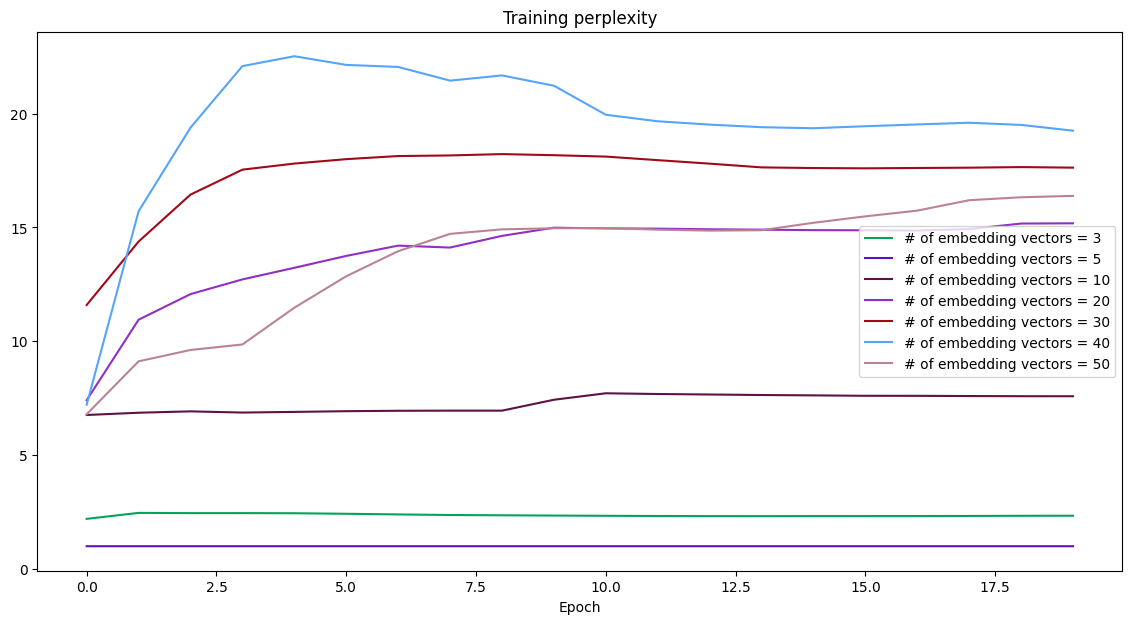

In [22]:
plt.figure(figsize=(14, 7))
legend_ = []

for index, (_,_, metrices) in enumerate(models_NumEmbeddings):
    color = np.random.rand(3,)
    plt.plot(metrices[1],color=color)
    legend_.append(f'# of embedding vectors = {NumEmbeddings[index]}')

plt.legend(legend_)
plt.title('Training perplexity')
plt.xlabel('Epoch')
plt.show()

- create GIF

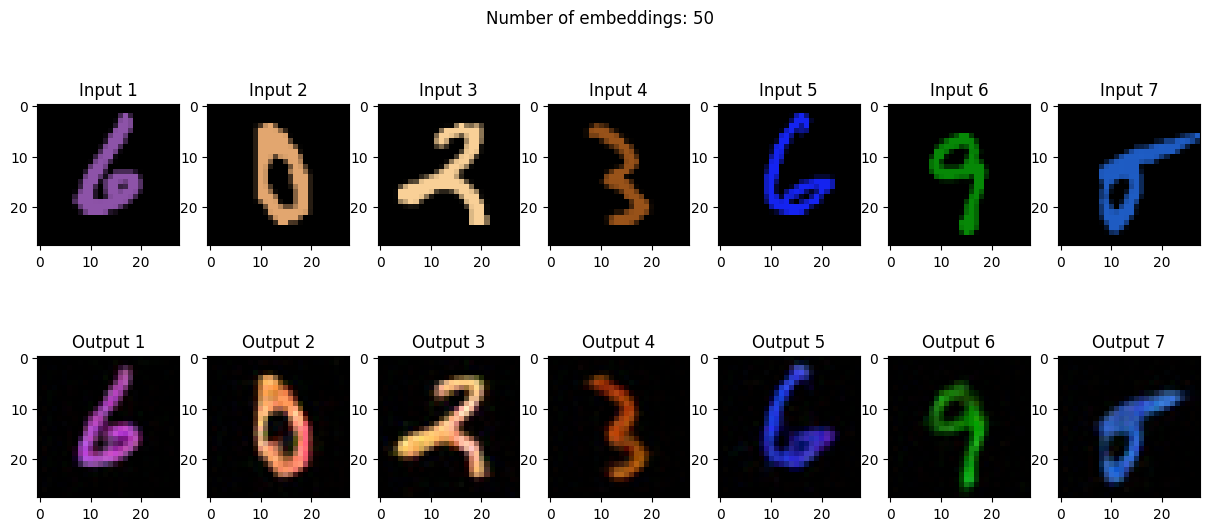

In [23]:
fig, ax = plt.subplots(2, 7, figsize=(15, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 7))

def update(frame):
    model,_, metrices = models_NumEmbeddings[frame]
    model.plot_some_output(coloured_loader, 7, device,ax)
    fig.suptitle(f'Number of embeddings: {NumEmbeddings[frame]}')

ani = FuncAnimation(fig, update, frames=7, repeat=False)
ani.save('/content/drive/My Drive/Q4/different_num_embedding.gif', writer='imagemagick', fps=2)
plt.show()



---
---
## Effect of dimention of embeddings

- training models

In [13]:
DimEmbeddings = [2, 5, 10, 20, 30, 40, 50]
models_DimEmbeddings = []

for num in tqdm(DimEmbeddings):
  model = VQ_VAE(input_dim=3, embedding_dim=num).to(device)
  optimizer = optim.Adam(model.parameters(), lr=5e-4)
  model, metrices = model.trainer(coloured_loader,optimizer,device=device,num_epochs=20,report =False)

  models_DimEmbeddings.append((model, optimizer,metrices))


100%|██████████| 7/7 [39:35<00:00, 339.35s/it]


- plot some example

Model with 2 embedding dimension:
final loss: 0.0344, final perplexity: 2.3317


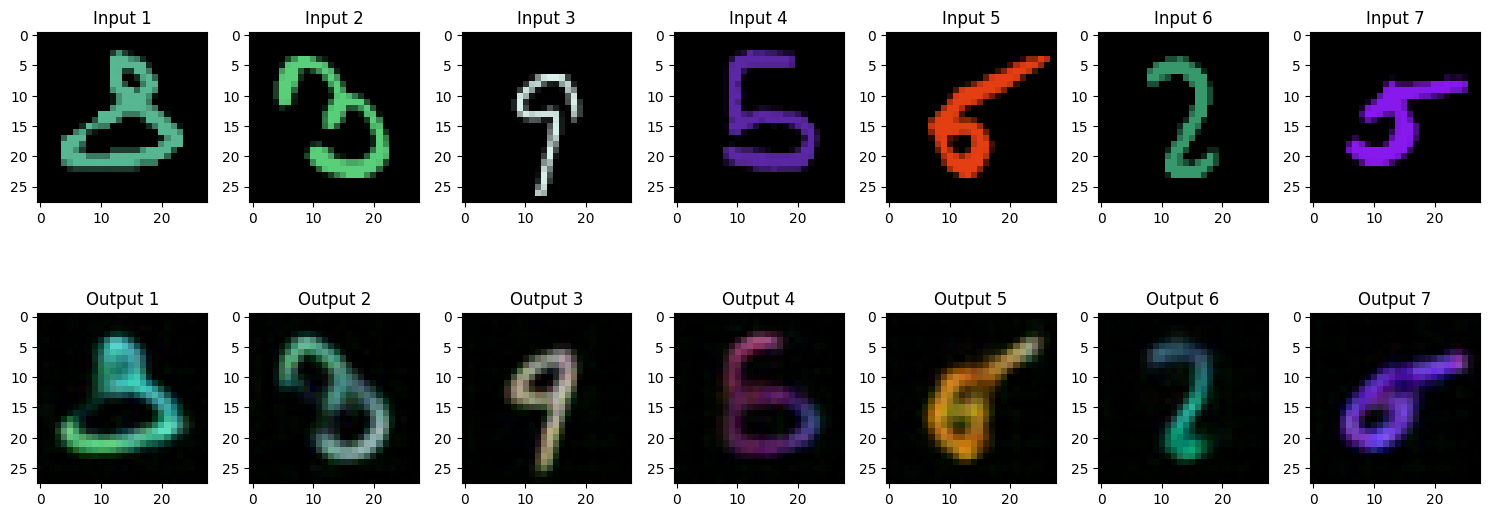

Model with 5 embedding dimension:
final loss: 0.0435, final perplexity: 2.3165


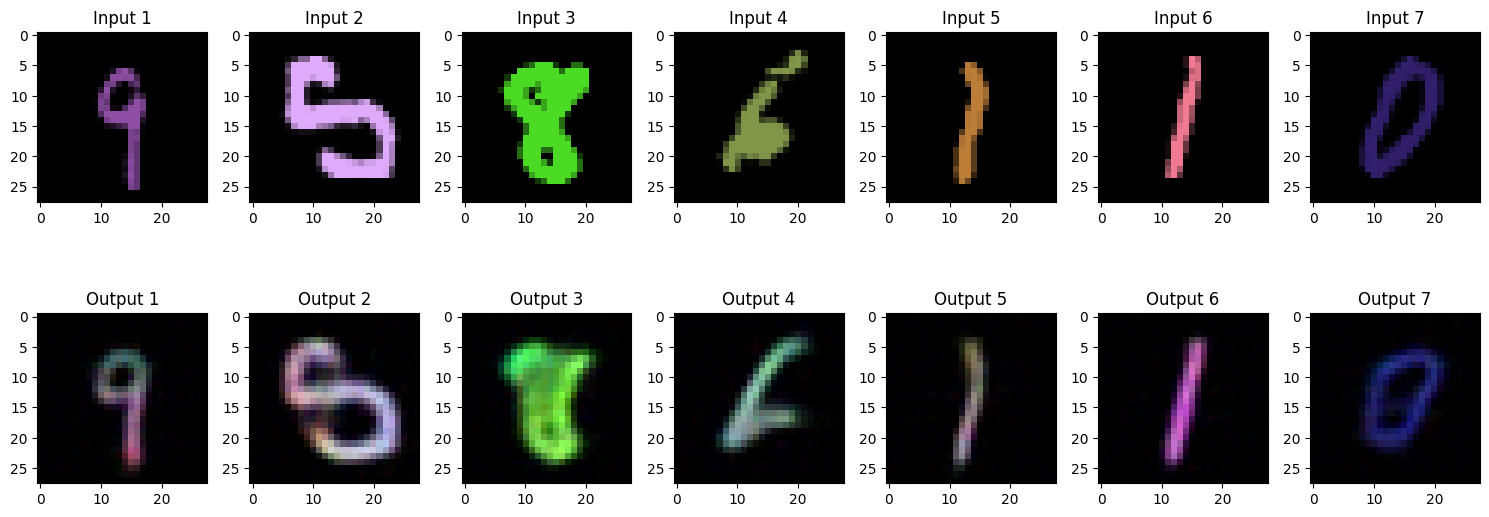

Model with 10 embedding dimension:
final loss: 0.0431, final perplexity: 2.3559


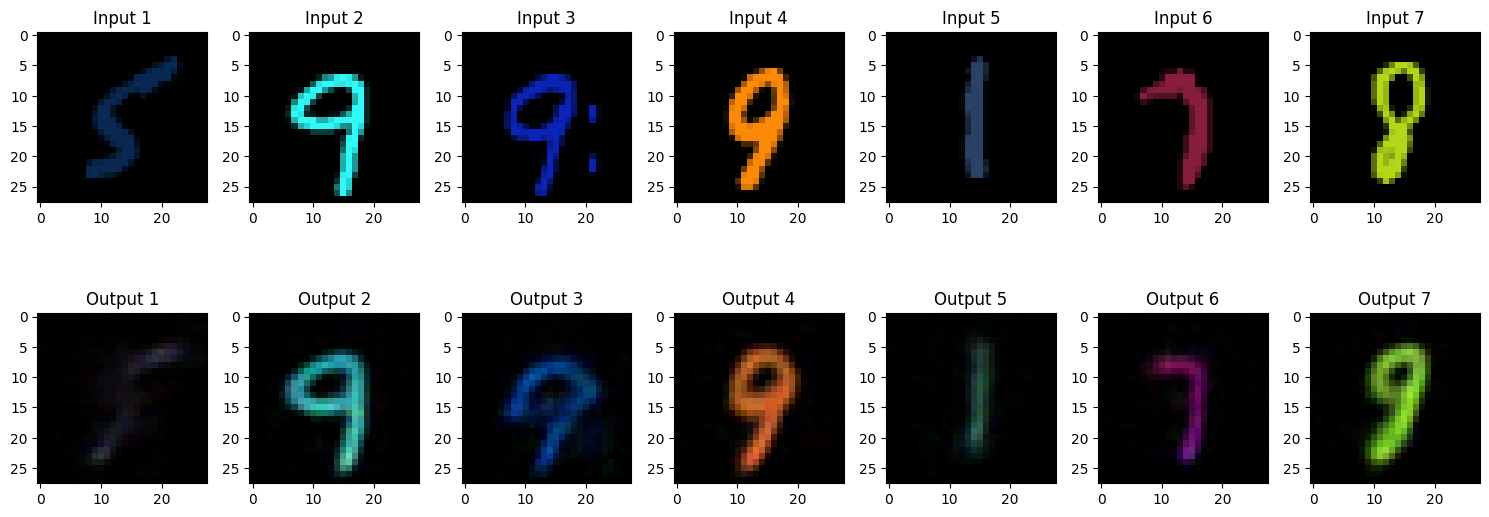

Model with 20 embedding dimension:
final loss: 0.0394, final perplexity: 2.3366


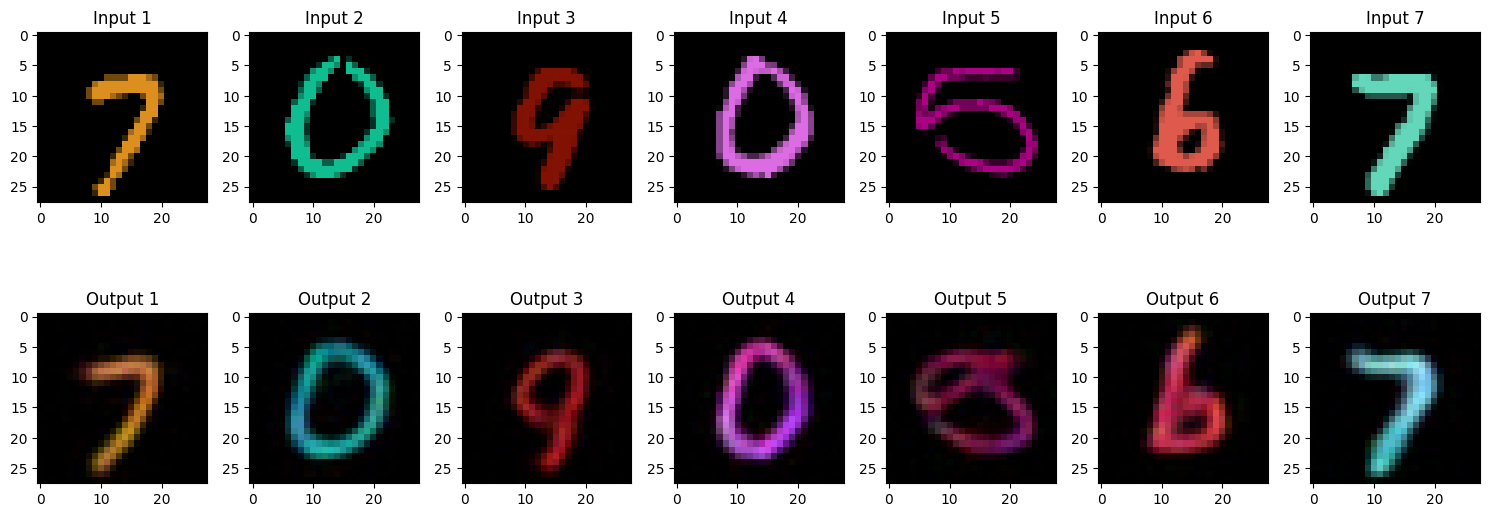

Model with 30 embedding dimension:
final loss: 0.0367, final perplexity: 1.8986


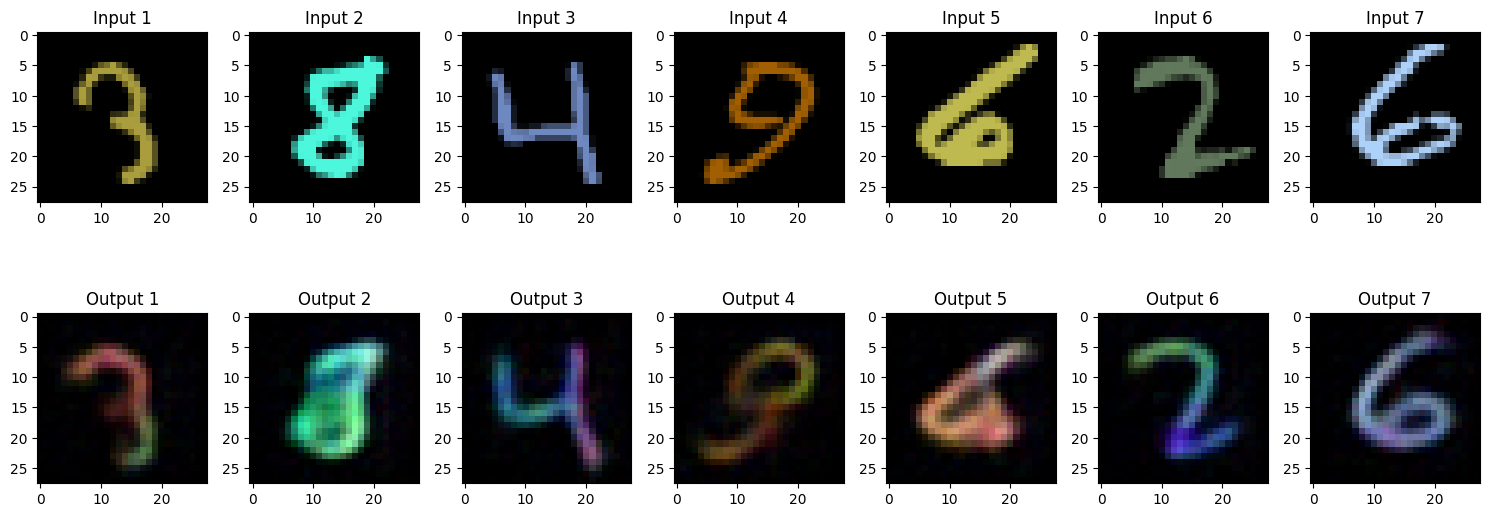

Model with 40 embedding dimension:
final loss: 0.0373, final perplexity: 2.5451


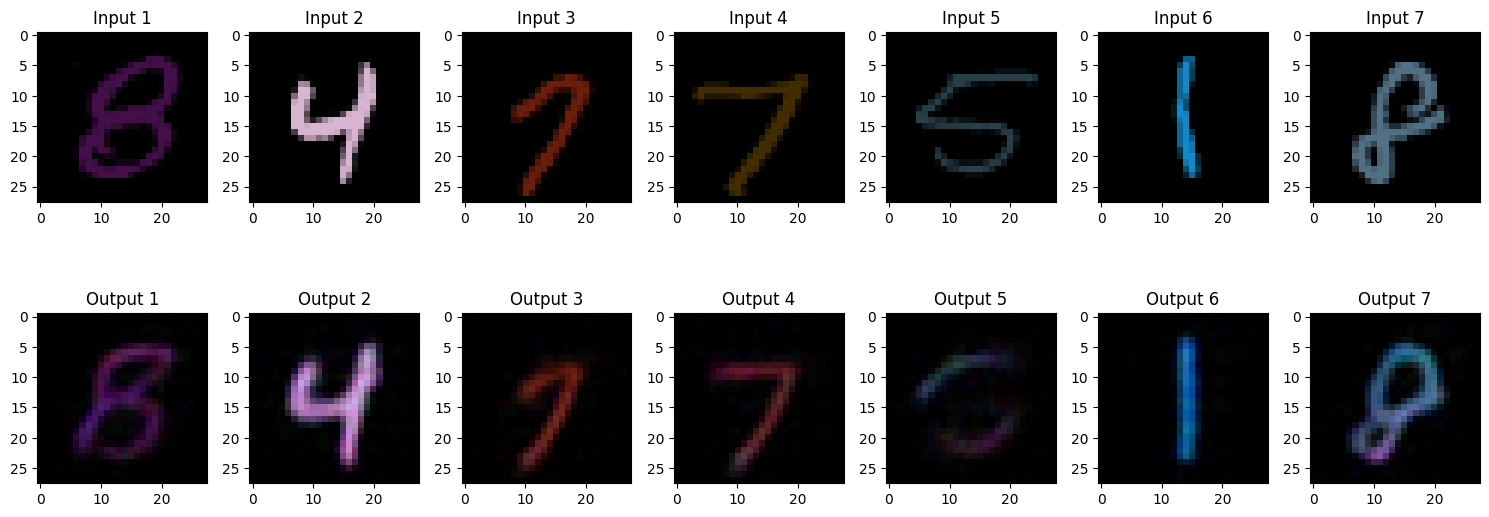

Model with 50 embedding dimension:
final loss: 0.0422, final perplexity: 1.8437


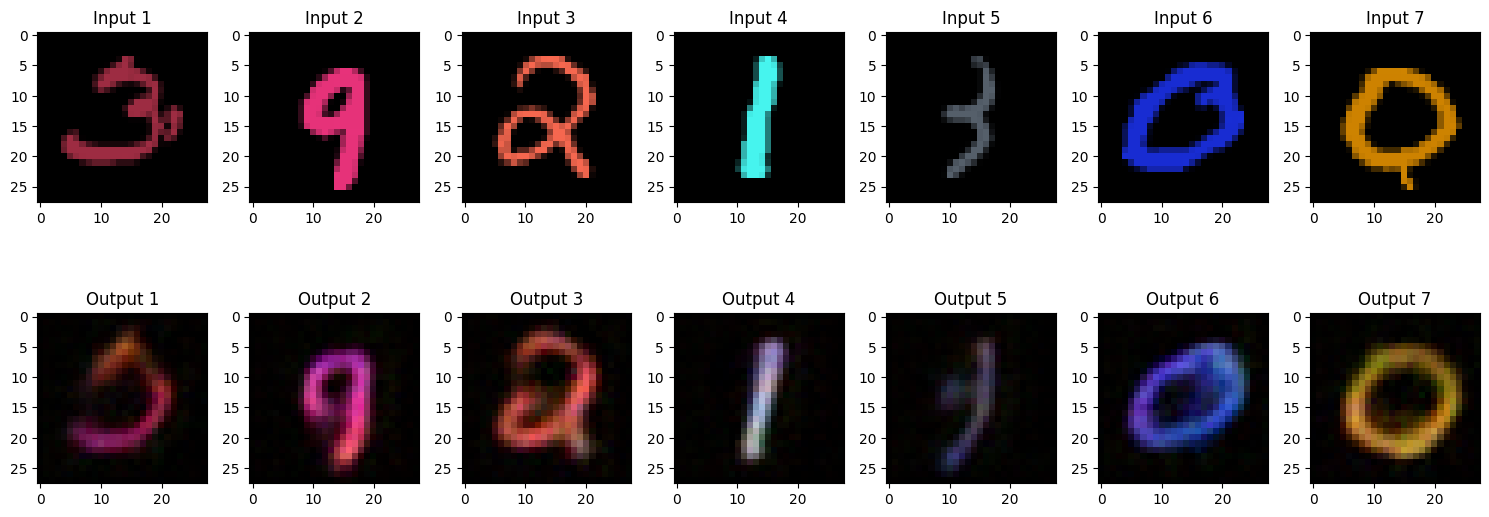

In [14]:
for index, (model,_, metrices) in enumerate(models_DimEmbeddings):
    print(f'Model with {DimEmbeddings[index]} embedding dimension:')
    final_loss = metrices[0][-1]
    final_perplexity = metrices[1][-1]
    print(f'final loss: {final_loss:.4f}, final perplexity: {final_perplexity:.4f}')
    model.plot_some_output(coloured_loader, 7, device)
    plt.tight_layout()
    plt.show()


- Compaire Training loss and perplexity

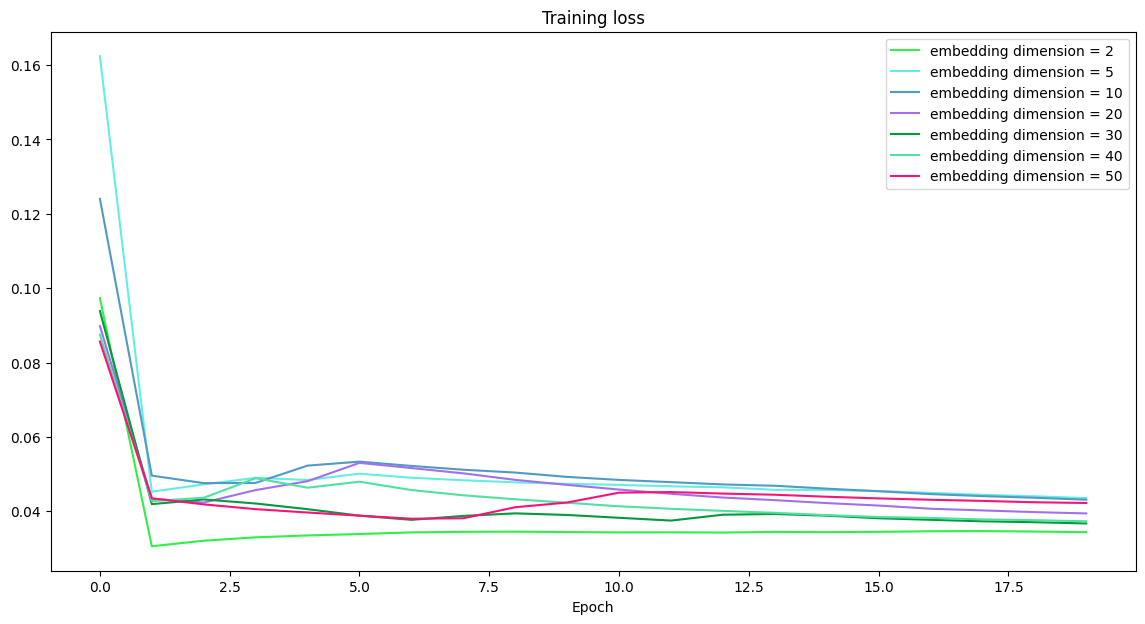

In [15]:
plt.figure(figsize=(14, 7))
legend_ = []

for index, (_,_, metrices) in enumerate(models_DimEmbeddings):
    color = np.random.rand(3,)
    plt.plot(metrices[0],color=color)
    legend_.append(f'embedding dimension = {DimEmbeddings[index]}')

plt.legend(legend_)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.show()


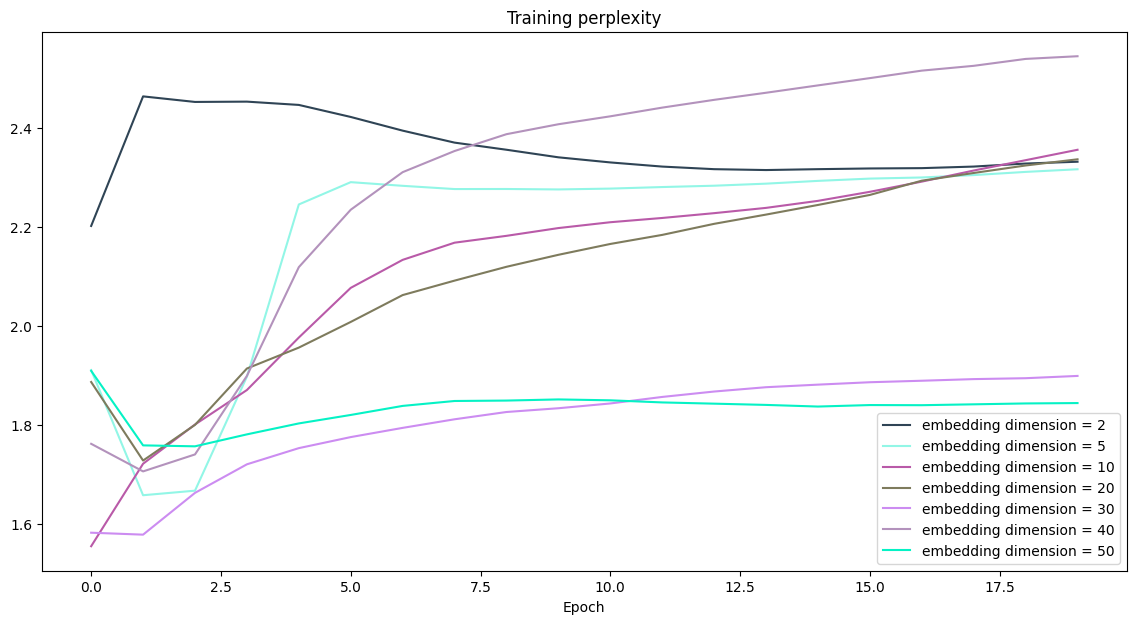

In [16]:
plt.figure(figsize=(14, 7))
legend_ = []

for index, (_,_, metrices) in enumerate(models_DimEmbeddings):
    color = np.random.rand(3,)
    plt.plot(metrices[1],color=color)
    legend_.append(f'embedding dimension = {DimEmbeddings[index]}')

plt.legend(legend_)
plt.title('Training perplexity')
plt.xlabel('Epoch')
plt.show()

- create GIF

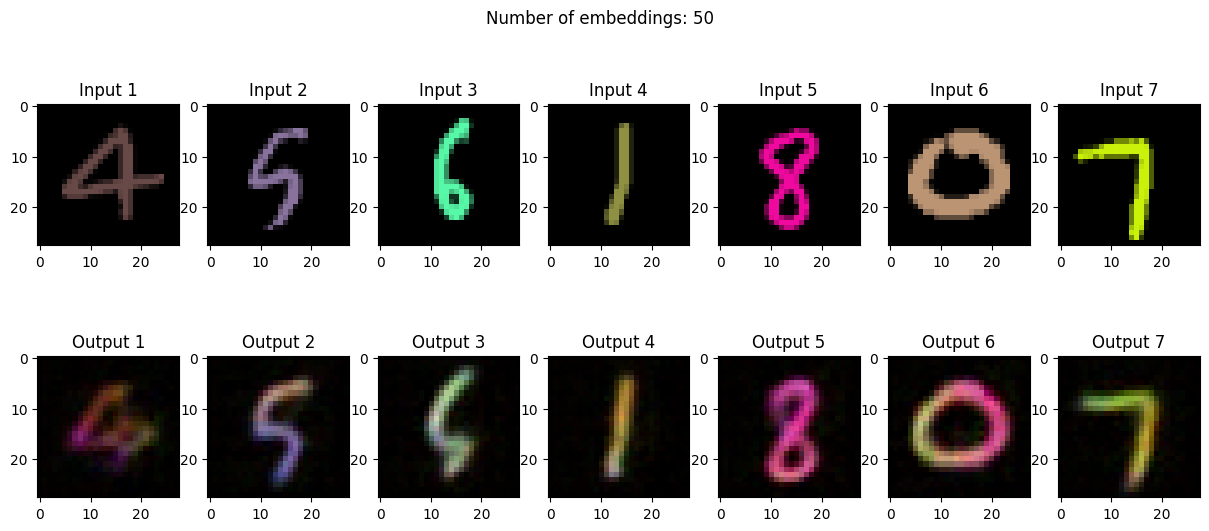

In [17]:
fig, ax = plt.subplots(2, 7, figsize=(15, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 7))

def update(frame):
    model,_, metrices = models_DimEmbeddings[frame]
    model.plot_some_output(coloured_loader, 7, device,ax)
    fig.suptitle(f'Number of embeddings: {DimEmbeddings[frame]}')

ani = FuncAnimation(fig, update, frames=7, repeat=False)
ani.save('/content/drive/My Drive/Q4/different_dim_embedding.gif', writer='imagemagick', fps=2)
plt.show()